In [189]:
from typing import Literal
import os
import re
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, pipeline, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset_builder, load_dataset, DatasetDict, concatenate_datasets, load_from_disk, Audio
import matplotlib.pyplot as plt
from evaluate import load

from pydub import AudioSegment
import speech_recognition as sr

# Inspecting & Preprocessing FLEURS Dataset

In [4]:
data_builder = load_dataset_builder("WueNLP/sib-fleurs", "tur_Latn")

data_builder.info.features

{'sentence': Value(dtype='string', id=None),
 'URL': Value(dtype='string', id=None),
 'id': Value(dtype='int32', id=None),
 'domain': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None),
 'has_image': Value(dtype='int32', id=None),
 'has_hyperlink': Value(dtype='int32', id=None),
 'fleurs_id': Value(dtype='int32', id=None),
 'filename': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'raw_transcription': Value(dtype='string', id=None),
 'transcription': Value(dtype='string', id=None),
 'num_samples': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'speaker_id': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'gender': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'whisper_asr': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'whisper_asr_cer': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None),
 'whisper_asr_wer': Sequence(feature=Va

In [124]:
category_map = {
    0: "science/technology",
    1: "travel",
    2: "politics",
    3: "sports",
    4: "health",
    5: "entertainment",
    6: "geography"
}

language_map = {
    "tur_Latn": "tr-TR",
    "eng_Latn": "en-US",
    "spa_Latn": "es-ES",
    "fra_Latn": "fr-FR",
    "deu_Latn": "de-DE"
}

In [136]:
def remove_cols(dataset, columns_to_remove):
    try:
        return dataset.remove_columns(column_names=columns_to_remove)
    except:
        return dataset

def add_language(dataset, language):
    dataset["language"] = language
    return dataset

def proprocess_topic(dataset):
    topic = dataset["topic"]
    splitted_topic = re.split(r"/", topic)

    new_topics = []
    for element in splitted_topic:
        splitted_element = re.split(r"_", element)
        new_element = " ".join(splitted_element)
        new_topics.append(new_element.lower())
    dataset["topic"] = ", ".join(new_topics)
    return dataset 

def create_hf_ddict(train_split, validation_split, test_split):
    return DatasetDict({"train": train_split,
                        "validation": validation_split,
                        "test": test_split})

In [147]:
load_from_local = True

if load_from_local:
    proc_dataset_dict = load_from_disk("./datasets/processed/proc_dataset_dict")
else:
    # Load datasets
    fleurs_tr_ddict = load_dataset("WueNLP/sib-fleurs", "tur_Latn")
    fleurs_en_ddict = load_dataset("WueNLP/sib-fleurs", "eng_Latn")
    fleurs_sp_ddict = load_dataset("WueNLP/sib-fleurs", "spa_Latn")
    fleurs_fr_ddict = load_dataset("WueNLP/sib-fleurs", "fra_Latn")
    fleurs_du_ddict = load_dataset("WueNLP/sib-fleurs", "deu_Latn")

    fleurs_tr_ddict.save_to_disk("./datasets/raw/fleurs_tr_ddict")
    fleurs_en_ddict.save_to_disk("./datasets/raw/fleurs_en_ddict")
    fleurs_sp_ddict.save_to_disk("./datasets/raw/fleurs_sp_ddict")
    fleurs_fr_ddict.save_to_disk("./datasets/raw/fleurs_fr_ddict")
    fleurs_du_ddict.save_to_disk("./datasets/raw/fleurs_du_ddict")

    dataset_dicts = {"tur_Latn": fleurs_tr_ddict, 
                    "eng_Latn": fleurs_en_ddict, 
                    "spa_Latn": fleurs_sp_ddict, 
                    "fra_Latn": fleurs_fr_ddict, 
                    "deu_Latn": fleurs_du_ddict}
    
    columns_to_remove = ["whisper_asr","whisper_asr_cer","whisper_asr_wer","whisper_asr_translation","seamlessm4t_asr","seamlessm4t_asr_cer","seamlessm4t_asr_wer","seamlessm4t_asr_translation",
                     "index_id","speaker_id","raw_transcription","transcription","has_image","has_hyperlink","id","sentence","URL","num_samples","filename"]

    splits = {"train": [],
            "validation":[],
            "test": []}
    for split in ["train","validation","test"]:
        for language, dataset_dict in dataset_dicts.items():
            dataset_dict[split] = remove_cols(dataset_dict[split], columns_to_remove)
            dataset_dict[split] = dataset_dict[split].map(lambda x: add_language(x, language_map[language]))
            dataset_dict[split] = dataset_dict[split].map(proprocess_topic)
            
            splits[split].append(dataset_dict[split])

    train_split = concatenate_datasets(splits["train"])
    val_split = concatenate_datasets(splits["validation"])
    test_split = concatenate_datasets(splits["test"])

    proc_dataset_dict = create_hf_ddict(train_split,val_split,test_split)

    proc_dataset_dict.save_to_disk("./datasets/processed/proc_dataset_dict")

In [148]:
proc_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 3595
    })
    validation: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 343
    })
    test: Dataset({
        features: ['domain', 'topic', 'fleurs_id', 'gender', 'category', 'text', 'audio', 'language'],
        num_rows: 857
    })
})

In [153]:
total_domains, total_topics, total_categories, total_genders, num_audios = {},{},{},{},{}

for split in ["train","test","validation"]:
    total_domain = defaultdict(int)
    total_topic = defaultdict(int)
    total_category = defaultdict(int)
    total_gender = defaultdict(int)
    num_audio = []
    for row in proc_dataset_dict[split]:
        domain = row["domain"]
        topic = row["topic"]
        category = row["category"]
        total_domain[domain] += 1
        total_topic[topic] += 1
        total_category[category] += 1
        num_audio.append(len(row["audio"]))
        for gender in row["gender"]:
            total_gender[gender] += 1
    
    total_domains[split] = total_domain
    total_topics[split] = total_topic
    total_categories[split] = total_category
    total_genders[split] = total_gender
    num_audios[split] = num_audio

In [160]:
print(total_domains["train"])
print(total_topics["train"])
print("Number of topics: {0}".format(len(total_topics["train"])))
print(total_categories["train"])
print(total_genders["train"])
print(num_audios["train"])

defaultdict(<class 'int'>, {'wikibooks': 1006, 'wikivoyage': 1321, 'wikinews': 1268})
defaultdict(<class 'int'>, {'geography, turkey': 19, 'world war ii, submarines': 19, 'natural wonders, hill stations in india': 10, 'travel, accomodation': 69, 'politics': 176, 'entertainment': 87, 'travel': 402, 'crime': 30, 'travel, archaeology': 5, 'science, radiography': 28, 'how things work, nuclear bomb': 5, 'internet, communication': 15, 'science, distance runner': 34, 'crime and law': 51, 'sports': 283, 'the elements, matter is the stuff around you': 24, 'south america, the amazon': 10, 'science, sensory systems': 15, 'communication theory, uses and gratifications': 5, 'science, earth science': 15, 'economy and business': 10, 'travel, food': 20, 'antartica, travel': 47, 'how things work, lightbulb': 10, 'science, first aid': 18, 'reason to travel, funeral travel': 15, 'disease': 15, 'video, dvd': 20, 'science': 88, 'culture and entertainment': 29, 'international': 10, 'how things work, ice ska

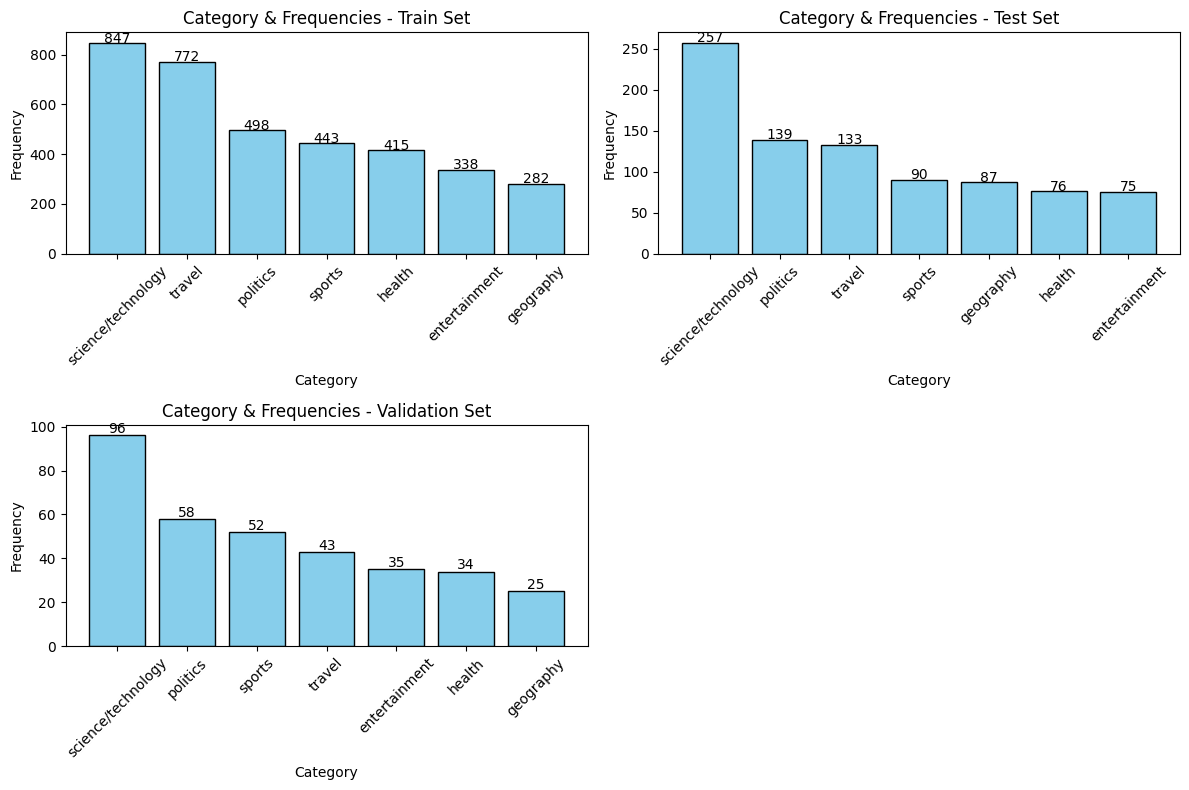

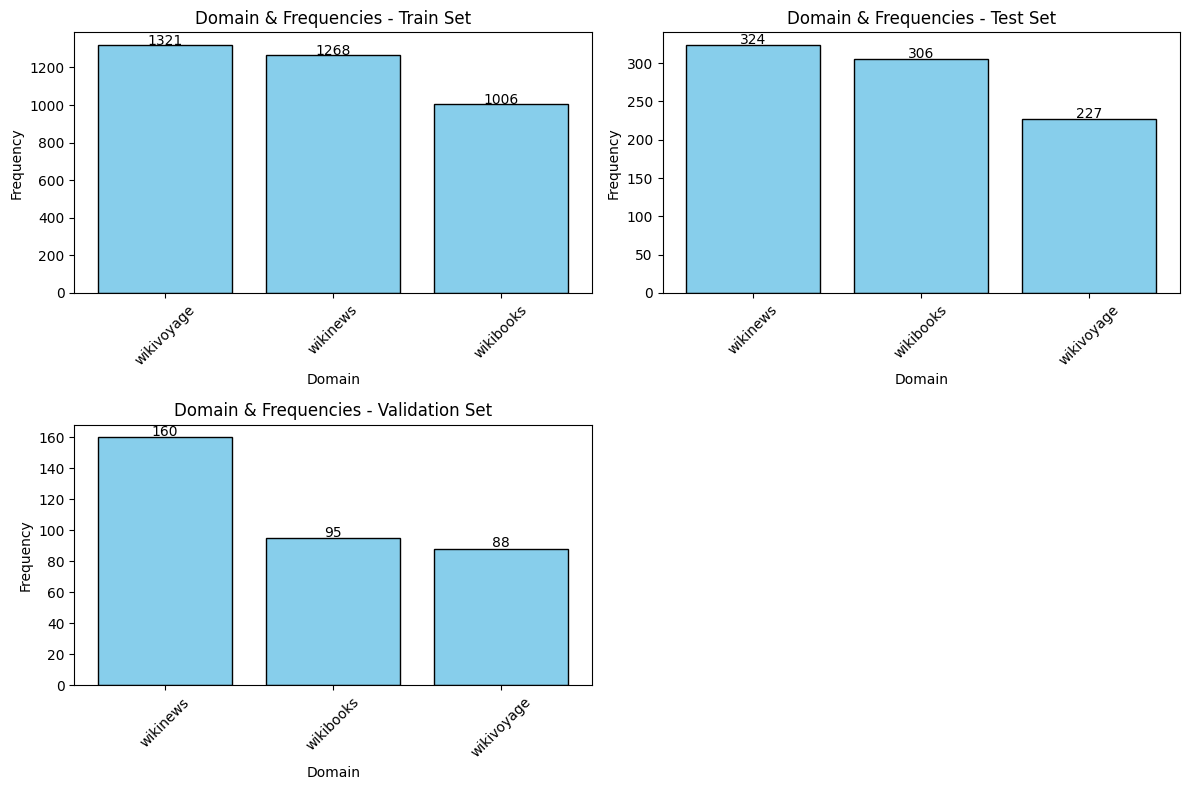

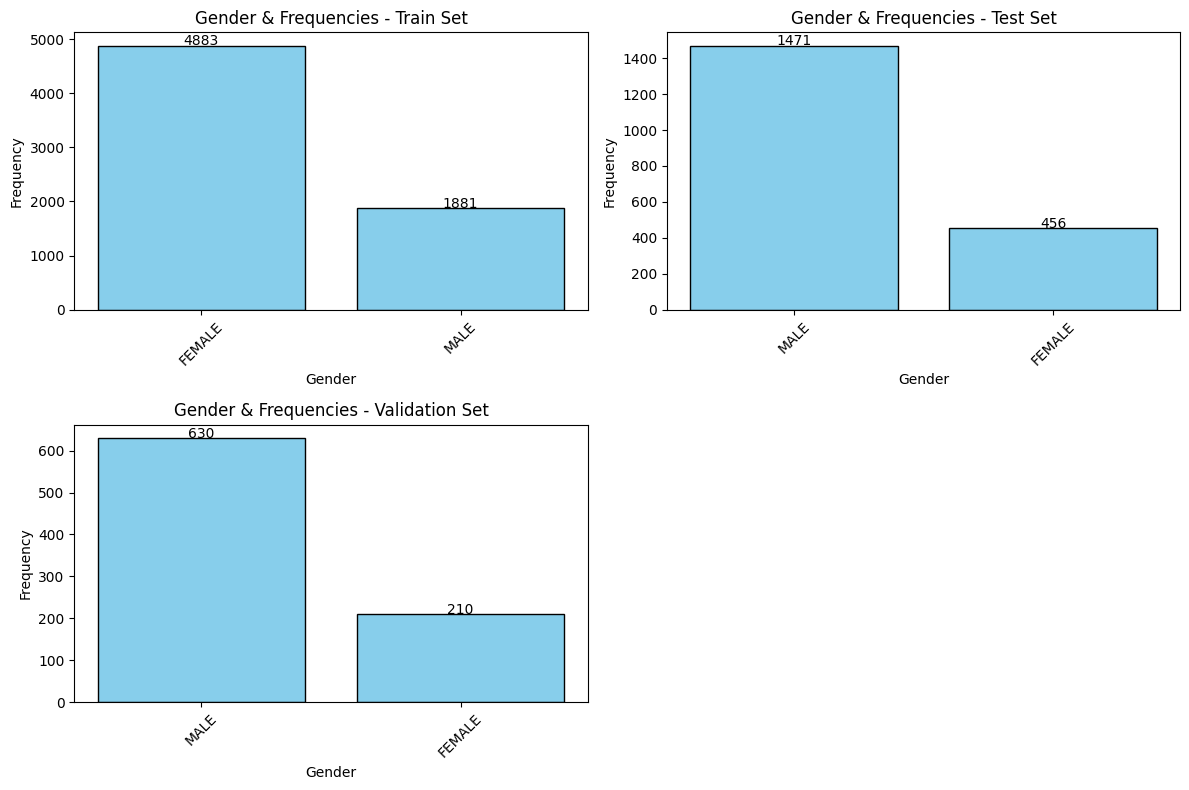

In [235]:
def plot_bar(ax, sorted_data, data_name, split):
    x_vals = list(sorted_data.keys())
    counts = list(sorted_data.values())

    if data_name=="Category":
        x_labels = [category_map[category] for category in x_vals]
        x_positions = range(len(x_vals))
    else:
        x_labels = x_vals
        x_positions = range(len(x_vals))

    # Create bar plot
    ax.bar(x_positions, counts, color='skyblue', edgecolor='black')
    # Set tick positions and labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45)

    ax.set_xlabel(data_name)
    ax.set_ylabel("Frequency")
    ax.set_title(f"{data_name} & Frequencies - {split} Set")
    
    # Show values on top of bars
    for i, count in enumerate(counts):
        ax.text(i, count + 1, str(count), ha='center', fontsize=10)

def make_frequency_subgraphs(data=total_categories, data_name: Literal["Category","Domain","Gender","Topic"]="Category"):
    # Sort categories for each dataset
    sorted_train = dict(sorted(data["train"].items(), key=lambda item: item[1], reverse=True))
    sorted_test = dict(sorted(data["test"].items(), key=lambda item: item[1], reverse=True))
    sorted_val = dict(sorted(data["validation"].items(), key=lambda item: item[1], reverse=True))

    # Create a figure with 2x2 subplots
    _, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Plot each dataset in its respective subplot
    plot_bar(axes[0, 0], sorted_train, data_name, "Train")
    plot_bar(axes[0, 1], sorted_test, data_name, "Test")
    plot_bar(axes[1, 0], sorted_val, data_name, "Validation")

    # Hide the bottom-right subplot 
    axes[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

make_frequency_subgraphs(data=total_categories, data_name="Category")
make_frequency_subgraphs(data=total_domains, data_name="Domain")
make_frequency_subgraphs(data=total_genders, data_name="Gender")

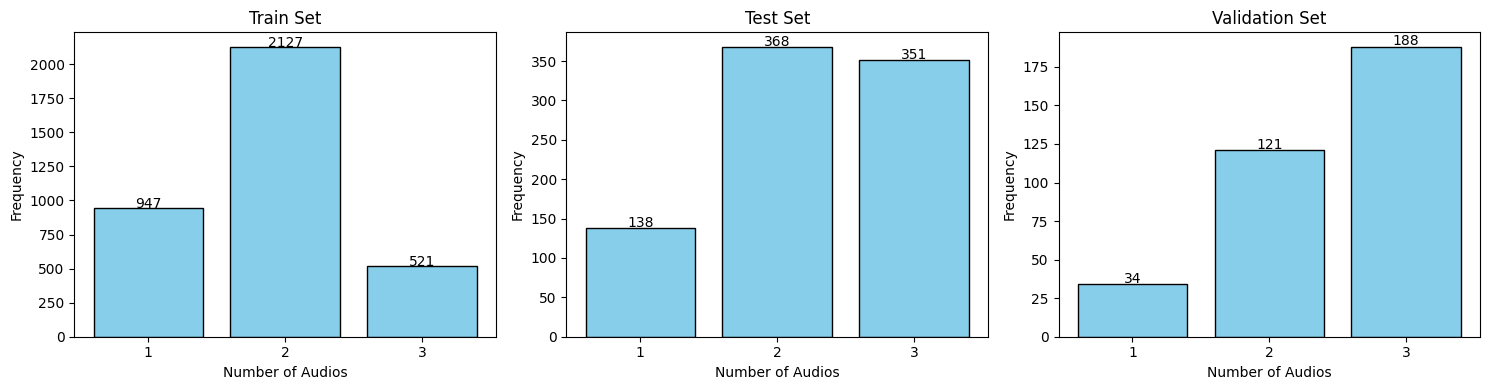

In [216]:
def plot_frequencies(ax, data, title):
    counts = Counter(data)
    vals = list(counts.keys())
    values = counts.values()

    ax.bar(vals, counts.values(), color='skyblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel("Number of Audios")
    ax.set_ylabel("Frequency")
    ax.set_xticks(vals)

    # Show values on top of bars
    for i, v in enumerate(values):
        ax.text(vals[i], v + 1, str(v), ha='center', fontsize=10)

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot for each dataset split
plot_frequencies(axes[0], num_audios["train"], "Train Set")
plot_frequencies(axes[1], num_audios["test"], "Test Set")
plot_frequencies(axes[2], num_audios["validation"], "Validation Set")

# Adjust layout and show
plt.tight_layout()
plt.show()


# Speech Recognition

In [236]:
train_set = proc_dataset_dict["train"]
sample = train_set[2600]

# Convert NumPy array to bytes
audio_array = sample["audio"][0]["array"]
fixed_audio_array = (audio_array * 2147483647).astype(np.int32)  # Scale for int32
audio_bytes = fixed_audio_array.tobytes()

# Create an AudioSegment
audio_segment = AudioSegment(
    data=audio_bytes,
    sample_width=4,
    frame_rate=train_set[0]["audio"][0]["sampling_rate"],
    channels=1)

In [237]:
# Save as a temporary WAV file (needed for speech recognition)
temp_wav_path = "temp_audio.wav"
audio_segment.export(temp_wav_path, format="wav")

# Initialize speech recognizer & load the temporary WAV file
recognizer = sr.Recognizer()
with sr.AudioFile(temp_wav_path) as source:
    audio_data = recognizer.record(source)

# Perform speech recognition
try:
    text = recognizer.recognize_google(audio_data,  language=sample["language"])
    print(f"Recognized Speech in {sample['language']}:", text)
    if os.path.exists(temp_wav_path):
        os.remove(temp_wav_path)
except sr.UnknownValueError:
    print("Speech recognition could not understand the audio")
except sr.RequestError:
    print("Could not request results from Google Speech Recognition")

Recognized Speech in fr-FR: en sa qualité de président de la sous-commission de surveillance et d'enquête qui relèvent de la Commission de l'énergie du commerce de la Chambre des Représentants monsieur Stearns cherche à savoir si les impôts servent à financer les avortements par le biais de la planification familiale
